In [5]:
import torch
from CLIP.clip import clip

In [6]:
clip_model_modify, clip_preprocess_modify = clip.load("./1save_weights/clip_weights/clip_best.pth", device=torch.device('cpu'), jit=False)
# ./clip_weights/best_model_all_feature.pt
clip_model_ori, clip_preprocess_ori = clip.load("./ViT-B-32.pt", device=torch.device('cpu'), jit=False)

In [ ]:
def compare_weights(model1, model2):
    different_layers = []
    for name1, param1 in model1.named_parameters():
        param2 = model2.state_dict()[name1]
        # print(param2)
        if not torch.equal(param1, param2):
            different_layers.append(name1)
    return different_layers
compare_weights(clip_model_modify, clip_model_ori)

In [8]:
def topK_process(model, text):
    # Encode and normalize the search query using CLIP
    text_token = clip.tokenize(text, truncate=True)
    tokens = text.split(' ')
    text_encoded, weight = model.encode_text(text_token)

    text_encoded /= text_encoded.norm(dim=-1, keepdim=True)
    attention_weights = weight[-1][0][1+len(tokens)][:2+len(tokens)][1:][:-1]
    # attention_weights = weight[-1][range(len(weight[-1])), tokens_lens][:, :1+max(tokens_lens)][:, 1:][:, :-1]
    return text_encoded, attention_weights


In [9]:
# clip_text = 'a person passes something to the right'
# clip_text_perb = 'a native passes something to the right'

# clip_text = 'person is walking normally in a circle'
# clip_text_perb = 'human is walking usually in a loop'

# clip_text = 'a man kicks something or someone with his left leg'
# clip_text_perb = 'a human boots something or someone with his left leg'

# Walking forward in an even pace 
# Going ahead in an even pace

# clip_text = 'a man jumps forward and swings his arms'
# clip_text_perb = 'a native bounds ahead and waves his arms'


In [22]:
clip_text = 'person is sitting down and looking around'
clip_text_perb = 'native is seating down and looking around'

In [23]:
import numpy
def visual_weights(model, clip_text=clip_text, clip_text_perb=clip_text_perb):
    model.eval()
    text, weight_ori = topK_process(model, clip_text)
    text_perb, weight_perb = topK_process(model, clip_text_perb)
    weight_ori_v = weight_ori.detach().cpu().numpy()/weight_ori.detach().cpu().numpy().sum()
    # print(weight_ori_v.sum())
    weight_perb_v = weight_perb.detach().cpu().numpy()/weight_perb.detach().cpu().numpy().sum()
    # print(f"text:{clip_text}, \n weight_ori:{weight_ori_v},\n text_perb:{clip_text_perb}, \n weight_perb:{weight_perb_v}")
    return clip_text, weight_ori_v, clip_text_perb, weight_perb_v

In [24]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def generate_colored_text_image(text, attention_weights):
    # text = text.split(' ')
    # attention_weights = [float(i) for i in attention_weights]
    fig, ax = plt.subplots(figsize=(len(text)+1, 1))
    ax.set_axis_off()
    
    # 计算文本块的数量
    num_words = len(text)
    
    # 计算每个文本块的宽度
    word_width = 0.95 / num_words  # 减少间距
    
    # 计算最小和最大的权重值
    min_weight = min(attention_weights)
    max_weight = max(attention_weights)
    
    # 设置颜色
    base_color = (1, 0.5, 0.5)  # 基础颜色为浅红色
    color_map = [(1, 0.95 - 0.3 * (weight - min_weight) / (max_weight - min_weight), 0.95 - 0.3 * (weight - min_weight) / (max_weight - min_weight), 0.8) for weight in attention_weights]  # 根据权重计算颜色
    
    # 生成文本并设置背景颜色
    x_position = 0
    for word, color in zip(text, color_map):
        rect = Rectangle((x_position, 0), word_width, 1, facecolor=color)
        ax.add_patch(rect)
        ax.text(x_position + word_width / 2, 0.5, word, ha='center', va='center', fontsize=14, color='black')  # 增大字体
        x_position += word_width
        
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig('text_attention.png', dpi=300)
    plt.show()



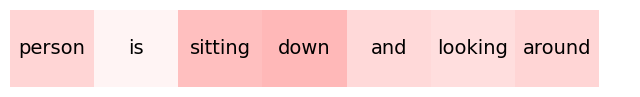

In [25]:
clip_text, weight_ori_v, clip_text_perb, weight_perb_v = visual_weights(clip_model_ori)
text = clip_text.split(' ')
attention_weights = [float(i) for i in weight_ori_v]

generate_colored_text_image(text, attention_weights)

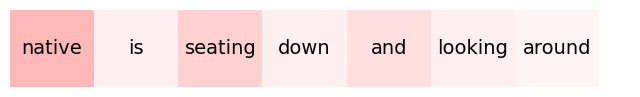

In [26]:
text = clip_text_perb.split(' ')
attention_weights = [float(i) for i in weight_perb_v]

generate_colored_text_image(text, attention_weights)

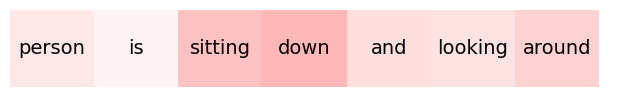

In [27]:
clip_text, weight_ori_v, clip_text_perb, weight_perb_v = visual_weights(clip_model_modify)
text = clip_text.split(' ')
attention_weights = [float(i) for i in weight_ori_v]
generate_colored_text_image(text, attention_weights)

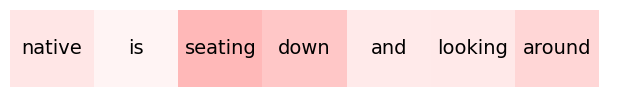

In [28]:
text = clip_text_perb.split(' ')
attention_weights = [float(i) for i in weight_perb_v]
generate_colored_text_image(text, attention_weights)

In [29]:
from scipy.spatial.distance import jensenshannon
def jsd_cal(model, clip_text, clip_text_perb):
    clip_text, weight_ori_v, clip_text_perb, weight_perb_v = visual_weights(model, clip_text, clip_text_perb)
    normalized_attention = weight_ori_v / weight_ori_v.sum()
    normalized_attention_perb = weight_perb_v / weight_perb_v.sum()
    jsd = jensenshannon(normalized_attention, normalized_attention_perb, base=2)
    return jsd

jsd_cal(clip_model_ori, clip_text, clip_text_perb)

0.3352644313389532

In [30]:
jsd_cal(clip_model_modify, clip_text, clip_text_perb)

0.08214502506975593